In [4]:
from astropy.io import fits

%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


This example notebook demonstrates how `pyTWR` radial modification of Tremaine-Weinderg method, introduced in https://arxiv.org/pdf/astro-ph/0511069.pdf, should be applied to real data.

In [5]:
import pytwr

# Data preparation

We will use the same CO data for **NGC 4736** from BIMA SONG survey https://ned.ipac.caltech.edu/level5/March02/SONG/SONG.html, as in the original paper.

We need FITS files for TWR: velocities map (moment 1) and surface densities (or intensities as equivalent, moment 0).

For correct estimation we also need to find in literature of measure information about positional angle (`PA`), distance to galaxy (`D`), size of pix in data in arcsec (`bima_scale`), galaxy center location on image and systemic velocity if moment 1 map not corrected for it. Additionally we also need to know inclination (`incl`) of the galaxy under consideration.

In [17]:
D = 4.3 # Mpc, thus dist_scale = 0.020846988287710047 kpc/arcsec

bima_scale = 1. # arcsec/pix

pix_kpc = bima_scale*0.020846988287710047 # kpc/pix

PA = 295. # deg

image_center = (177.5, 171.5) # image center in pix

incl = 35. # deg

v_syst = 308. # km/s, see Table 1 in arxiv.org/pdf/astro-ph/0304294.pdf

Load data and take a look at it:

In [18]:
fname = './NGC4736.bima12m.gmom1.fits'
mom1data = fits.getdata(fname)
mom1data[np.isnan(mom1data)] = 0.
#print(mom1data.shape)
fname = './NGC4736.bima12m.mmom0.fits'
mom0data = fits.getdata(fname)
mom0data[np.isnan(mom0data)] = 0.

/home/guzel/LALA/QQQ/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/guzel/LALA/QQQ/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


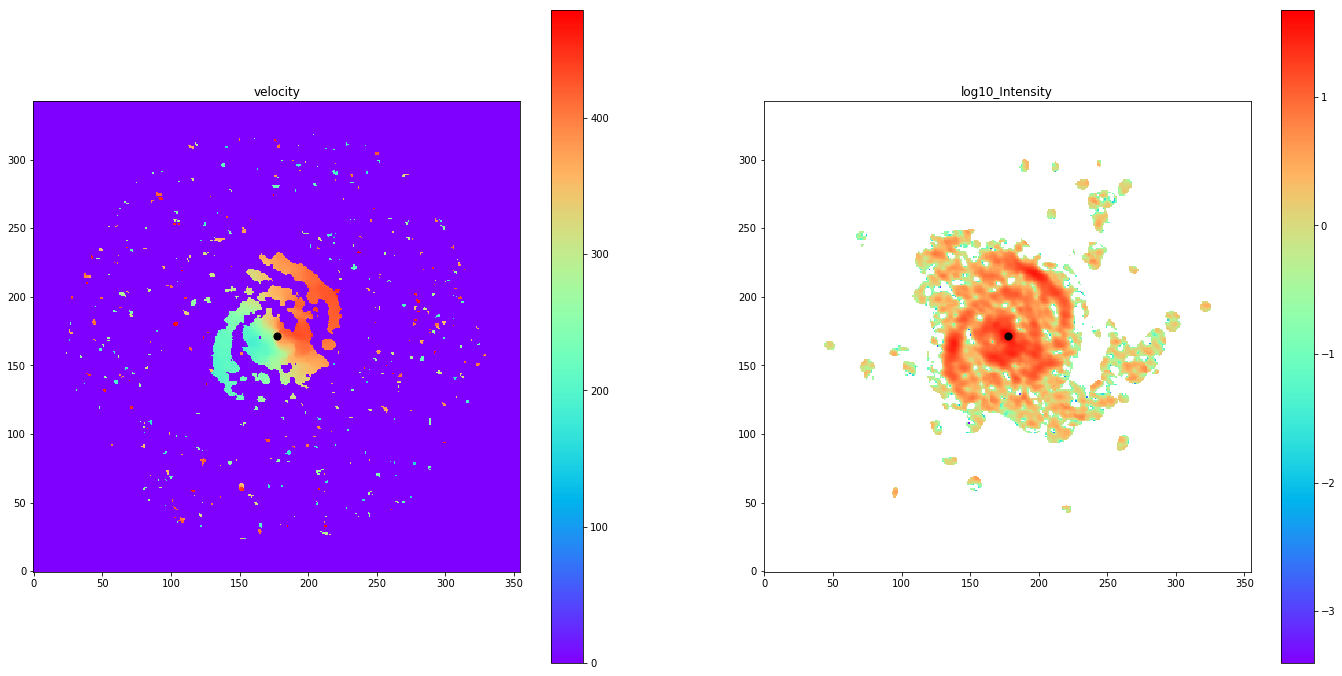

(1, 1, 343, 355)

In [20]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(mom1data), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(mom0data)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()
#mom1data.shape
shape(mom0data)
#mom1data[0,0,:,:].shape[0]

Let's rotate both maps thus so major axis align parallel to X-axis. *Note that you sometimes you need to use 90+PA instead of PA, just keep an eye on resulted image.*

In [21]:
plane_v = np.zeros((343, 355))
plane_intens = np.zeros((343, 355))
plane_v = pytwr.rotate_image(mom1data[0,0,:,:], angle=295.+90., center=image_center)
plane_intens = pytwr.rotate_image(mom0data[0,0,:,:], angle=295.+90., center=image_center)

Subtract systemic velocity:

In [22]:
plane_v = plane_v - v_syst
plane_v[plane_v < -v_syst+0.001] = 0. # to keep all pixs with zero signal

/home/guzel/LALA/QQQ/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/guzel/LALA/QQQ/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


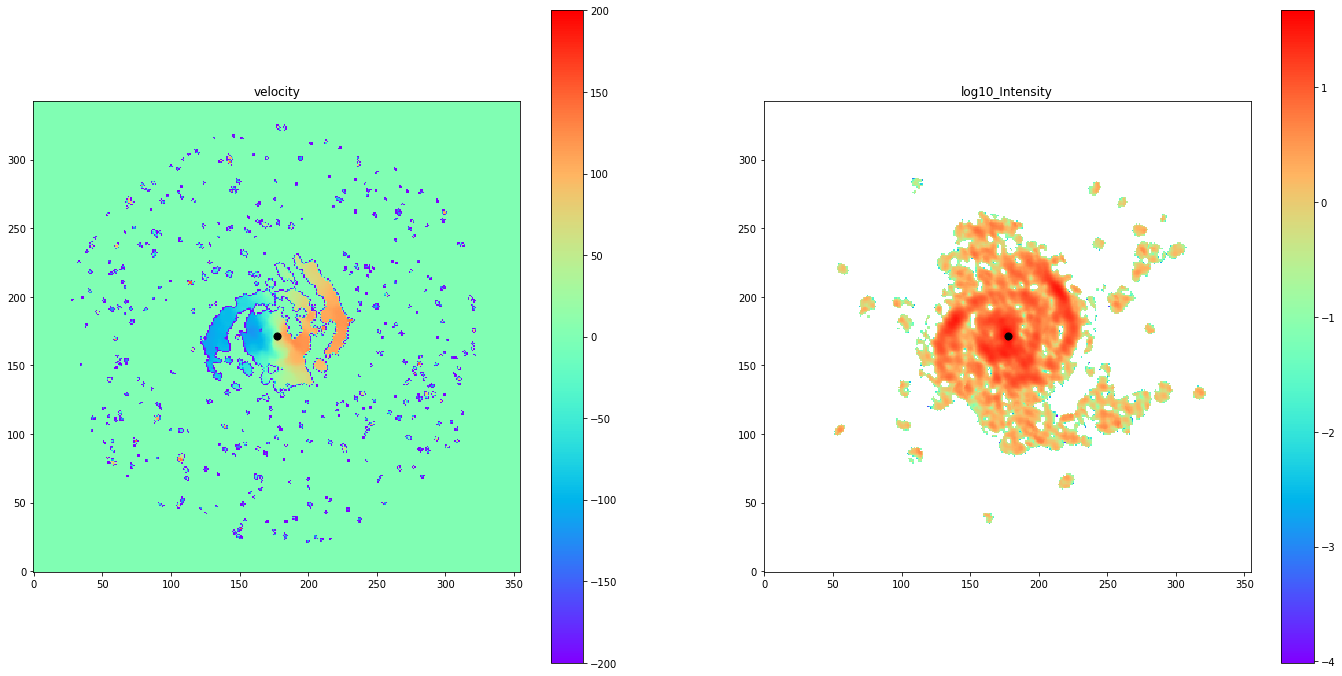

In [24]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(plane_v), origin='lower', cmap='rainbow', vmin=-200, vmax=200)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(plane_intens)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()

Make sure that velocities on Y-axis are close to zero, which mean the PA rotation and systemic velocity are correct.

Data is ready now for pattern velocity search.

# Application of TWR

To find pattern speeds we need to select side of the galaxy we will use (y>0 or y<0) and solve Eq. (3) from https://arxiv.org/pdf/0711.4104.pdf numerically. To do so, we need to cut galaxy to ellipses (see Fig. 1 in the same page), choose limits of integration `X_lim` and solve triangular matrix equation.

How we cut to ellipses is an essential part, because this determines on which radii we will detect pattern speed $\Omega$ (and its variations). Usually it is natural to have cuts of the same width, so we need to choose `ymin` - offset from the galaxy's center in pix (or, in other words, where we start the first ellipse. This is needed if you want to avoid bar, etc.), `delta_y` - step between cuts and number of cuts `y_bins`. 

Let's illustrate this for y>0 side:

/home/guzel/LALA/QQQ/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/guzel/LALA/QQQ/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


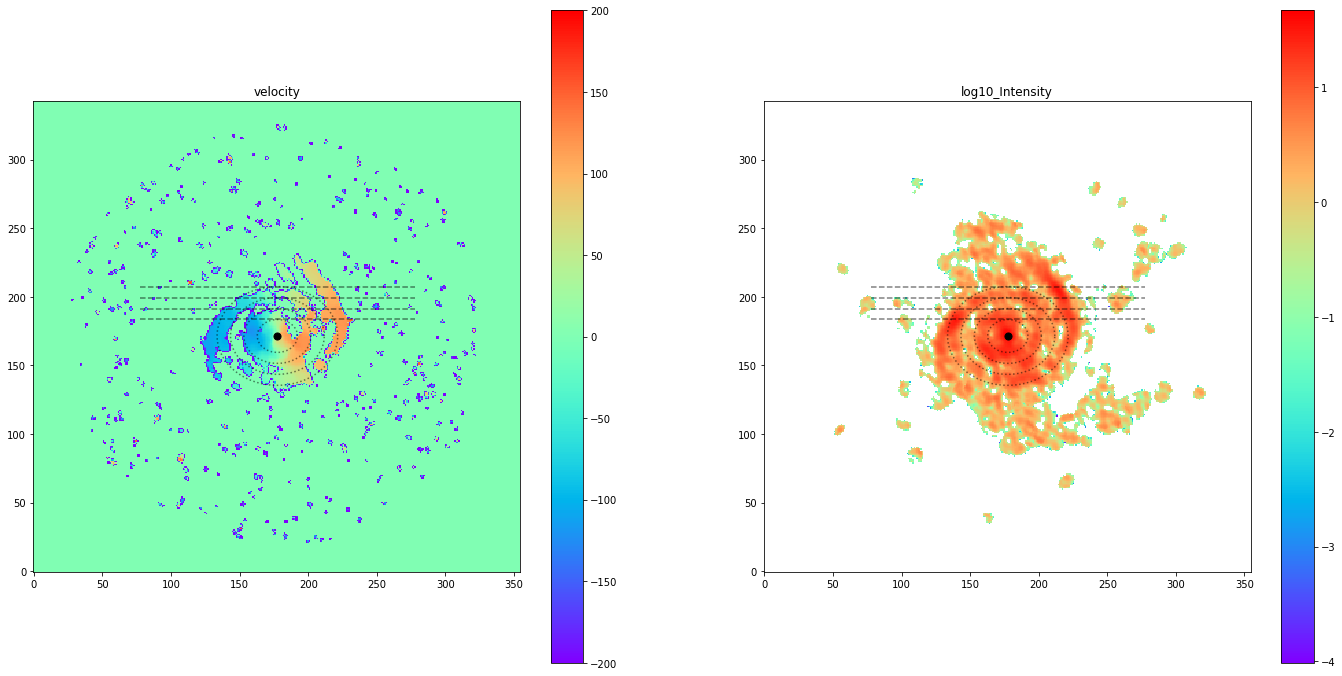

In [36]:
ymin = 12.
y_bins = 3
delta_y = 8.
X_max = 100.
            
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(plane_v), origin='lower', cmap='rainbow', vmin=-200, vmax=200)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

pytwr.add_ells(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=image_center, incl=incl)

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(plane_intens)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

pytwr.add_ells(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=image_center, incl=incl)

plt.show()

There are 3 radial bins, because the inner one is just offset and not included. Let's show how TWR can be applied for exactly the same set of parameters:

In [37]:
%%time
omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                             center=image_center, incl=incl,
                             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                             verbose=False, 
                             r_scale=pix_kpc, 
                             lim_frame=True)

CPU times: user 1min 19s, sys: 13.1 s, total: 1min 32s
Wall time: 1min 9s


Besides already known parameters there are three additional:

* `verbose` constrols if you want to see additional prints and pictures for better understanding and debugging (example below)
* `r_scale` is just a scale in kpc/pix to convert $\Omega$ to proper units
* `lim_frame` works for `verbose=True` only and regulate if we see the full image or just part of it

Returned values are list of pattern speeds in km/s/kpc and radial bins in pix:

In [39]:
omega, rrs

(array([ 13315.52547573, -10094.49789364,  -4116.09928496]),
 [14.649295065137473, 24.41549177522912, 34.18168848532077, 43.94788519541242])

Let's plot them:

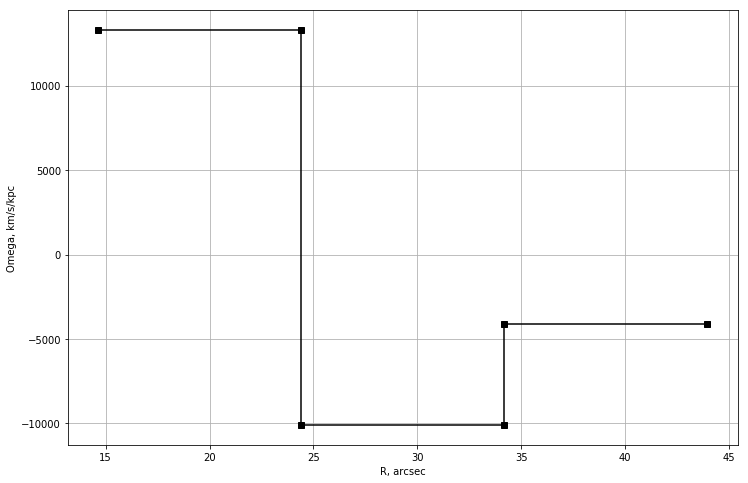

In [40]:
fig = plt.figure(figsize=[12,8])
ax = plt.gca()
tmp = []
for ind, om in enumerate(omega):
    tmp.append([rrs[ind]*bima_scale, om])
    tmp.append([rrs[ind+1]*bima_scale, om])
tmp = np.array(tmp)
ax.plot(tmp[:, 0], tmp[:, 1], '-s', color='k')
ax.grid()
plt.xlabel('R, arcsec')
plt.ylabel('Omega, km/s/kpc')
plt.show()

Thus we can conclude that for such parameters $\Omega$ is not constant and vary in the disk.

Let's run the same TWR with `verbose=True`:

/home/guzel/LALA/QQQ/pyTWR-master/pytwr.py:120: RuntimeWarning: divide by zero encountered in log2
  im = plt.imshow(np.squeeze(np.log2(intens)), origin='lower', cmap='rainbow')
/home/guzel/LALA/QQQ/pyTWR-master/pytwr.py:120: RuntimeWarning: invalid value encountered in log2
  im = plt.imshow(np.squeeze(np.log2(intens)), origin='lower', cmap='rainbow')


radial bins: {rrs}

K:
  [[ -28.1317224    12.41865224 -113.5842042 ]
 [   0.            8.58494882  -18.24654595]
 [   0.            0.           -4.36329024]]
b:
  [-32424.86344802 -11556.1529956   17959.73585485]
Omega: [ 13315.52547573 -10094.49789364  -4116.09928496]
Residuals: [-5.82076609e-11  0.00000000e+00  3.63797881e-12]


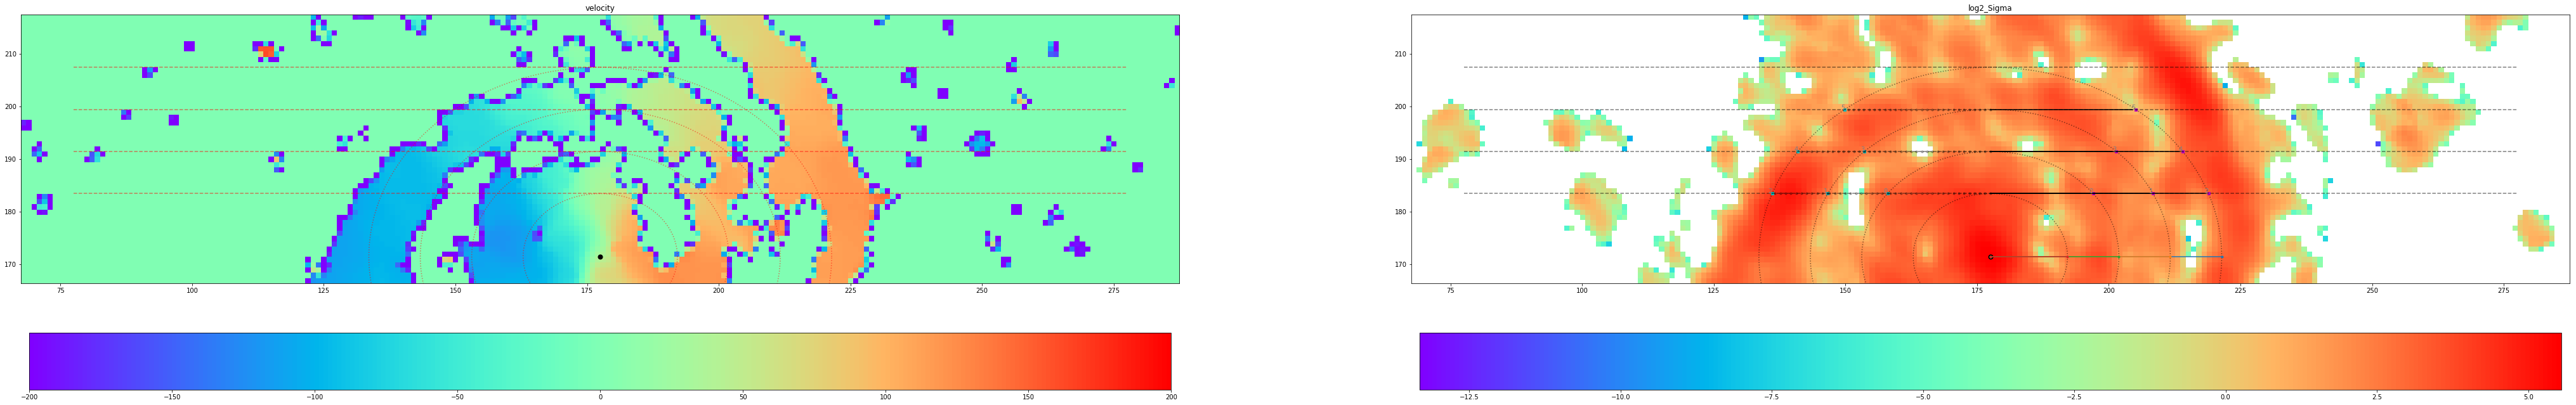

In [41]:
omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                             center=image_center, incl=incl,
                             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                             verbose=True, 
                             r_scale=pix_kpc, 
                             lim_frame=True)

We now see additional information, including matrix, right side of the equation, residuals of solution and two additional plots, which shows location of ellipses and integration limits.